In [48]:
import pandas as pd
from tabulate import tabulate
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [12]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
online_retail = fetch_ucirepo(id=352)
# data (as pandas dataframes)
X = online_retail.data.ids.join(online_retail.data.features)

In [ ]:
#Looking at the first few rows of the dataset
print(X.head(10))

In [14]:
#printing shape of dataset
print("Shape of dataset:", X.shape)

Shape of dataset: (541909, 8)


In [ ]:
#to check the categorical and numeric columns
print(X.dtypes)

In [ ]:
#checking for null values
print(X.isnull().sum())

In [ ]:
#check the invoice column values
print(X['InvoiceNo'].value_counts())

In [18]:
#checking invoice columns
print(f"Normal Invoices: {X['InvoiceNo'].str.isnumeric().sum()}")
print(f"Cancellations (start with 'C'): {X['InvoiceNo'].str.startswith('C').sum()}")

Normal Invoices: 532618
Cancellations (start with 'C'): 9288


In [ ]:
#checking quantity column
print(X['Quantity'].value_counts())
#output shows that the some quantity are neagtive

In [20]:
#checking for neagtive qunatity values
print(f"Cancelled orders:{(X['Quantity']<0).sum()}")
# negative quantity indicate the cancelled order

Cancelled orders:10624


In [21]:
# checking for bulk orders
print(f"Bulk orders:{(X['Quantity']>30).sum()}")

Bulk orders:25858


In [22]:
# Quantile analysis of order quantities
quantity_stats = X['Quantity'].describe(percentiles=[0.9, 0.95, 0.99])
print(quantity_stats[['max', '99%', '95%', '90%', 'mean', '50%']].to_frame().T)

              max    99%   95%   90%     mean  50%
Quantity  80995.0  100.0  29.0  24.0  9.55225  3.0


In [ ]:
#checking the top selling countries 
print(X['Country'].value_counts())

In [ ]:
#checking stock code column
#checking for numeric values
print(f"Numeric values:{X['StockCode'].str.isnumeric().sum()}")

#checking for alpha numeric values
print(f"Alphanumeric values: {X['StockCode'].str.isalnum().sum()}")

In [ ]:
print(X.describe())

In [25]:
# Summary statistics
summary = {
    "Total records": len(X),
    "Unique Items": X['StockCode'].nunique(),
    "Unique Invoices": X['InvoiceNo'].nunique(),
    "Unique Customers": X['CustomerID'].nunique(),
    "Countries": X['Country'].nunique(),
     "Time Range": f"{pd.to_datetime(X['InvoiceDate']).min().date()} to {pd.to_datetime(X['InvoiceDate']).max().date()}"
}

# Display summary as a table
summary_table = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
print("Summary of Online Retail Dataset:\n")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))


Summary of Online Retail Dataset:

+------------------+--------------------------+
| Metric           | Value                    |
+==================+==========================+
| Total records    | 541909                   |
+------------------+--------------------------+
| Unique Items     | 4070                     |
+------------------+--------------------------+
| Unique Invoices  | 25900                    |
+------------------+--------------------------+
| Unique Customers | 4372                     |
+------------------+--------------------------+
| Countries        | 38                       |
+------------------+--------------------------+
| Time Range       | 2010-12-01 to 2011-12-09 |
+------------------+--------------------------+


#### 1a) Overview of data
The dataset contains 25,900 unique transactions of retail purchases from 2010-12-01 to 2011-12-09 in 38 countries. There are around 9288 canceled orders. The stock code contains some alphanumeric values like 85123A, which initially should be 5-digit integral number, which further needs to be investigated. The description is missing for some products. The UK dominates with 82% of transactions. Approximately 25% of records lack customer IDs, suggesting guest logins. The high quantity orders suggest that some customers are wholesalers and also has some outliers like max quantity 80995. Overall, the data shows typical retail patterns like frequent small purchases (median 3 items/transaction), occasional high-value orders, and returns/cancel orders (negative quantities). 

In [ ]:
#1b
# Preprocess data for association rules

# Filtering valid transactions (exclude cancellations and returns)
valid_trans = X[~X['InvoiceNo'].str.startswith('C', na=False) & (X['Quantity'] > 0)]

#preparing for one hot encoding 
# Group items by transaction
basket_data = valid_trans.groupby('InvoiceNo')['StockCode'] \
                    .apply(list) \
                    .reset_index(name='Items')
# Encode transaction data
te = TransactionEncoder()
basket_df = te.fit_transform(basket_data['Items'])
basket_df= pd.DataFrame(basket_df, columns=te.columns_)
print(basket_df)


In [ ]:
# 1.b Example

#group data
grouped = valid_trans.groupby('InvoiceNo')['StockCode'].apply(list)

# Encode transactions
te = TransactionEncoder()
encoded_df = te.fit_transform(grouped)
encoded_df = pd.DataFrame(encoded_df, columns=te.columns_, index=grouped.index)

# Display example with boolean values
print("Encoded Transaction 536365")
example = encoded_df.loc['536365'].sort_values(ascending=False)  # Sort by True/False
display(pd.DataFrame({
    'StockCode': example.head(10).index, 
    'Present': example.head(10).values
}))

#### 1B Association rule mining
Data preprocessing is done to prepare for association rule mining algorithm like Apriori. First, data filtering is applied to exclude cancellations (identified by InvoiceNo starting with ‘C’) and transactions with negative quantities, as these represent returns or reversed purchases rather than genuine customer intent. For instance, removing invoice “C536365” ensures the analysis focuses on actual sales, avoiding distortions in market basket patterns. Next, items are grouped by transaction (InvoiceNo), creating itemsets. This allows us to identify frequently bought-together products. 
| InvoiceNo | Items                         |
|-----------|-------------------------------|
| 536365    | ['85123A', '71053', '84406B'] |
| 536366    | ['22633', '22632']            |

One-hot encoding is applied using transaction encoder, where each row represents a transaction, and columns correspond to unique StockCodes, with True/False values indicating item presence. 
| 22632 | 22633 | 71053 | 84406B | 85123A |
|-------|-------|-------|--------|--------|
| False | False | True  | True   | True   |
| True  | True  | False | False  | False  |

While the approach introduces limitations, such as high dimensionality (4,070 unique StockCodes) and the loss of contextual data like quantities or prices, these are mitigated by techniques like frequency filtering (e.g., excluding items appearing in fewer than 0.1% of transactions) and a focus on co-occurrence patterns over transactional details.


In [28]:
##1C
# Select features
clustering_data = X[['Quantity', 'UnitPrice', 'Country']].dropna()

#Encoding categorical features
country_encoder = OneHotEncoder(sparse_output=False)
country_encoded = country_encoder.fit_transform(clustering_data[['Country']])

#Scaling numerical features
scaler = MinMaxScaler()
num_encoded = scaler.fit_transform(clustering_data[['Quantity', 'UnitPrice']])

#Combining features
final_data = np.hstack([num_encoded, country_encoded])

#### 1C Encoding features for clustering
The data was prepared by selecting key features : `Quantity,UnitPrice` and `Country`. Missing values were removed to ensure clean input.Since clustering algorithms are sensitive to feature scales and data types, we applied **Min-Max normalization** to scale the numerical features and **One-Hot Encoding** to convert the categorical Country feature into binary vectors.<br> Finally, the processed data was combined into a single matrix.
For example, consider the following transactions:
| InvoiceNo | Quantity | UnitPrice | Country         |
|-----------|----------|-----------|------------------|
| 536365    | 6        | 2.55      | United Kingdom   |
| 536366    | 3        | 3.39      | France           |
| 536367    | 2        | 7.65      | Germany          |

For numerical features Quantity and UnitPrice, let’s use min-max Normalization. <br>
Assuming, <br> 
`Quantity min = 1, max = 12`<br>
`UnitPrice min = 0.85, max = 15.00`<br>
For categorical feature Country, One-Hot encoding is used.<br>
Finally, after encoding these transactions will look like this:<br>
| Scaled Quantity | Scaled UnitPrice | United Kingdom | France | Germany |
|-----------------|------------------|----------------|--------|---------|
| 0.4545          | 0.1205           | 1              | 0      | 0       |
| 0.1818          | 0.1793           | 0              | 1      | 0       |
| 0.0909          | 0.4806           | 0              | 0      | 1       |

This transformation allows the clustering algorithm to measure similarity across all features equally, improving clustering performance.


In [ ]:
results=[]

freq_itemsets = apriori(basket_df, min_support=0.1, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
results.append({
        'Support': 0.1,
        'Itemsets': len(freq_itemsets),
        'Max Size': freq_itemsets['length'].max(),
        'Example Itemset': freq_itemsets.sort_values('support', ascending=False).iloc[1]['itemsets']
})
# Create results table
results_df = pd.DataFrame(results)
print(freq_itemsets.head())
print(results_df[['Support', 'Itemsets', 'Max Size', 'Example Itemset']])

In [ ]:
results=[]

freq_itemsets_001 = apriori(basket_df, min_support=0.01, use_colnames=True)
freq_itemsets_001['length'] = freq_itemsets_001['itemsets'].apply(lambda x: len(x))
results.append({
        'Support': 0.01,
        'Itemsets': len(freq_itemsets_001),
        'Max Size': freq_itemsets_001['length'].max(),
        'Example Itemset': freq_itemsets_001.sort_values('support', ascending=False).iloc[3]['itemsets']
})
# Create results table
results_df = pd.DataFrame(results)
print(freq_itemsets_001.head())
print(results_df[['Support', 'Itemsets', 'Max Size', 'Example Itemset']])

In [62]:
results=[]

freq_itemsets = apriori(basket_df, min_support=0.05, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
results.append({
        'Support': 0.05,
        'Itemsets': len(freq_itemsets),
        'Max Size': freq_itemsets['length'].max(),
        'Example Itemset': freq_itemsets.sort_values('support', ascending=False).iloc[0]['itemsets']
})
# Create results table
results_df = pd.DataFrame(results)
print(freq_itemsets.head())
print(results_df[['Support', 'Itemsets', 'Max Size', 'Example Itemset']])

    support itemsets  length
0  0.075502  (20725)       1
1  0.061415  (20727)       1
2  0.055481  (20728)       1
3  0.063682  (21212)       1
4  0.057121  (21931)       1
   Support  Itemsets  Max Size Example Itemset
0     0.05        32         1        (85123A)


#### 2A Applying Apriori Algorithm
The Apriori algorithm reveals that higher support thresholds focus on only the most common items, while lower thresholds capture a broader range of purchasing patterns. At 0.10 support, only 2 frequent itemsets are found—mainly popular standalone products like item 85123A. As support decreases to 0.05, we see more frequent single-item purchases. At 0.01, the model uncovers 1840 itemsets, including combinations of up to 4 items. This suggests customers often purchase items in small groups, but these patterns only emerge with relaxed thresholds. Lower support values uncover more complex and rare purchase patterns, while high thresholds focus only on the most frequently bought items.<br>

##### Results table:
| Support | Frequent Itemsets | Max Itemset Size | Example Itemset |
|---------|-------------------|------------------|-----------------|
| 0.10    | 2                 | 1                | (85099B)        |
| 0.05    | 32                | 1                | (85123A)        |
| 0.01    | 1840              | 4                | (47566)

In [65]:
#2b 
#freq_itemsets_001
#Generating association rules with support 0.01
rules = association_rules(freq_itemsets_001, metric="lift", min_threshold=1.0)

#Filter high confidence & lift
strong_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 3)].sort_values('lift', ascending=False)

#Displaying the insights
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

def get_description(items):
    return [product_mapping.get(item, item) for item in items]



     antecedents consequents   support  confidence       lift
1352     (22917)     (22916)  0.010662    0.920833  80.536006
1353     (22916)     (22917)  0.010662    0.932489  80.536006
1354     (22918)     (22916)  0.010276    0.894958  78.272950
1355     (22916)     (22918)  0.010276    0.898734  78.272950
1359     (22917)     (22918)  0.010372    0.895833  78.020308


In [ ]:
#Mapping stock code and description
product_mapping = X[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()
herb_codes = X[X['Description'].str.contains('HERB MARKER', na=False)]['StockCode'].unique()
herb_codes = X[X['Description'].str.contains('lost in space', na=False)]['StockCode'].unique()
basket_filtered = basket_df.drop(columns=herb_codes, errors='ignore')

# generating association rules with support 0.01
freq_itemsets_new = apriori(basket_filtered, min_support=0.01, use_colnames=True)
rules_new = association_rules(freq_itemsets_new, metric="lift", min_threshold=1)

def get_description(items):
    return [product_mapping.get(item, item) for item in items]

# Format the rules with descriptions
insights = rules_new.head(12).assign(
    Rule = lambda x: "If buys " + x['antecedents'].apply(
        lambda s: ', '.join(get_description(s))) + \
                     ", then buys " + x['consequents'].apply(
        lambda s: ', '.join(get_description(s))),
    Action = "Bundle products | Cross-promote | Adjacent placement"
)[['Rule', 'support', 'confidence', 'lift', 'Action']]

#first few insights
print("Top Actionable Insights:")
display(insights.style.hide(axis='index').set_properties(**{'text-align': 'left'}))

In [63]:
#Generating association rules with support 0.05
rules = association_rules(freq_itemsets, metric="lift", min_threshold=0.05)

#Filter high confidence & lift
strong_rules = rules[(rules['confidence'] > 0.5) & (rules['lift'] > 1.2)].sort_values('lift', ascending=False)

#Displaying the insights
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


#### 2b) Association rules
Using the APriori algorithm with support threshold of 0.01 and filtering rules by high confidence(>0.7) and lift(>3) reveals strong product associations.For example, the rule “If a customer buys HERB MARKER ROSEMARY, they also buy HERB MARKER THYME” has a very high confidence of 92% and an exceptionally high lift of 80.5, indicating that customers frequently purchase these together. Similarly, themed or color-matched items, such as the PINK POLKADOT BOWL and BLUE POLKADOT BOWL, also demonstrate a strong association (confidence: 62%, lift: 40.2), reinforcing the potential of cross-promotion within product families. The WOODLAND CHARLOTTE BAG and JUMBO BAG WOODLAND ANIMALS also show a positive lift, indicating customers often purchase multiple items within a theme or design series. These insights support strategies like bundling, cross-promotion, and adjacent placement in stores or online layouts.
| Rule                                                                                      | support   | confidence | lift      | Action                                          |
|-------------------------------------------------------------------------------------------|-----------|------------|-----------|-------------------------------------------------|
| If customer buys HERB MARKER ROSEMARY, they also buy HERB MARKER THYME                   | 0.010662  | 0.920833   | 80.536006 | Bundle products \| Cross-promote \| Adjacent placement |
| If customer buys PINK POLKADOT BOWL, they also buy BLUE POLKADOT BOWL                    | 0.010035  | 0.624625   | 40.208755 | Bundle products \| Cross-promote \| Adjacent placement |
| If customer buys WOODLAND CHARLOTTE BAG, they also buy JUMBO BAG WOODLAND ANIMALS        | 0.011144  | 0.276647   | 6.644650  | Bundle products \| Cross-promote \| Adjacent placement |
| If customer buys JUMBO BAG WOODLAND ANIMALS, they also buy LUNCH BAG RED SPOTTY          | 0.011530  | 0.276941   | 3.668007  | Bundle products \| Cross-promote \| Adjacent placement |
| If customer buys RED TOADSTOOL LED NIGHT LIGHT, they also buy JUMBO BAG WOODLAND ANIMALS | 0.010903  | 0.266196   | 6.393628  | Bundle products \| Cross-promote \| Adjacent placement |

However, when the support threshold was increased to 0.05, no frequent itemsets met the criteria. This is likely due to the high dimensionality and sparsity of the dataset, where customers buy from a wide variety of items, often only once or twice. Therefore, using a lower support value is more appropriate for this dataset, as it allows the discovery of meaningful but less frequent associations that are still valuable for targeted marketing and product placement decisions.


In [ ]:
##3a
# TotalSpend = Quantity * UnitPrice
X['TotalSpend'] = X['Quantity'] * X['UnitPrice']

# Group by customer
customer_X = X.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Frequency
    'Quantity': 'sum',
    'TotalSpend': 'sum'
}).rename(columns={
    'InvoiceNo': 'Frequency',
    'Quantity': 'TotalQuantity'
}).reset_index()

# Add average spend per transaction
customer_X['AvgSpendPerOrder'] = customer_X['TotalSpend'] / customer_X['Frequency']

#Selecting features
features = customer_X[['Frequency', 'TotalQuantity', 'TotalSpend', 'AvgSpendPerOrder']]

#Scaling the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

#Using KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=19330026) #random state is studentid
customer_X['Cluster'] = kmeans.fit_predict(X_scaled)

#Summarizing results including number of customers
cluster_summary = customer_X.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Frequency': 'mean',
    'TotalQuantity': 'mean',
    'TotalSpend': 'mean',
    'AvgSpendPerOrder': 'mean'
}).rename(columns={'CustomerID': 'Num_Customers'})

(cluster_summary.round(2))

#### 3a) Applying clustering technique
The customers were segmented based on their purchasing behavior using clustering approach. For this, four features such as number of invoices i.e `purchase frequency`, `total quantity`(calculated from unit price), `total spending`, and average spend per order were selected. These features were normalised using **MinMaxScaler**, and further KMeans Clustering algorithm was applied. Based on customer purchase patterns, 4 clusters were selected. Finally, each cluster was summarised by the number of customers and average values of the selected features to interpret purchasing behavior across groups. These clustering results can help businesses with targeted marketing strategies and offer more personalized services to each type of customer.<br>

| Cluster | Num_Customers | Frequency | TotalQuantity | TotalSpend | AvgSpendPerOrder |
|---------|----------------|-----------|----------------|-------------|-------------------|
| 0       | 4092           | 4.07      | 669.29         | 1101.40     | 262.00            |
| 1       | 105            | 41.50     | 10353.03       | 16956.90    | 439.56            |
| 2       | 7              | 82.86     | 86332.71       | 168745.32   | 2871.65           |
| 3       | 168            | 3.57      | 2837.92        | 4949.15     | 1444.56           |


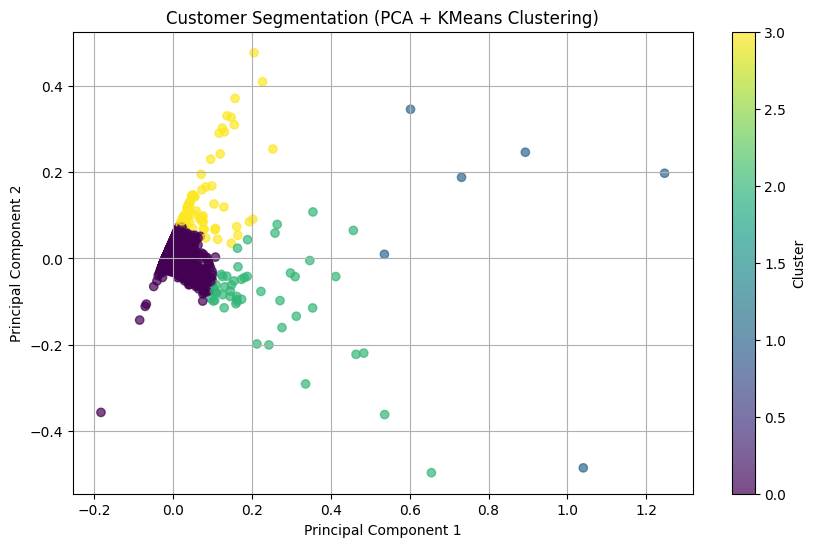

In [44]:
##3b
# 1. Customer Segmentation scatter plot
# Using the same features used for clustering
X_cluster_input = customer_X[['Frequency', 'TotalQuantity', 'TotalSpend', 'AvgSpendPerOrder']]
X_scaled = scaler.fit_transform(X_cluster_input)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Plotting the clusters in 2D PCA space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], 
                      c=customer_X['Cluster'], cmap='viridis', alpha=0.7)
plt.title("Customer Segmentation (PCA + KMeans Clustering)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


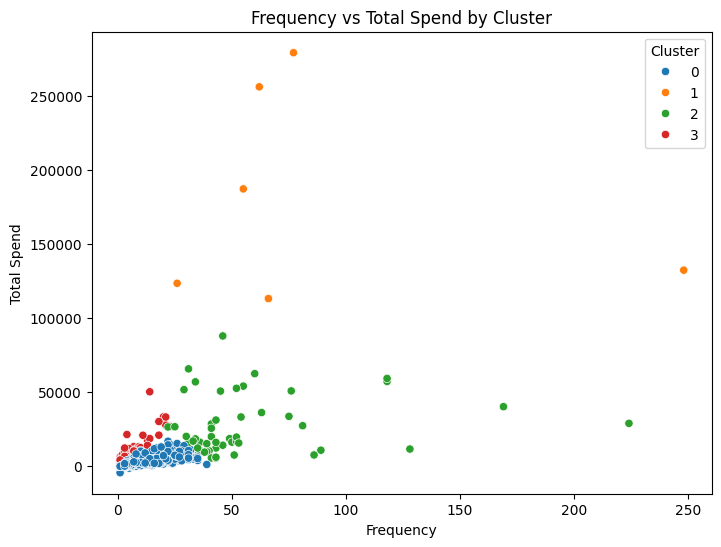

In [39]:
##3b
# 2. Scatter Plot: Frequency vs TotalSpend
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_X, x='Frequency', y='TotalSpend', hue='Cluster', palette='tab10')
plt.title('Frequency vs Total Spend by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Total Spend')
plt.legend(title='Cluster')
plt.show()

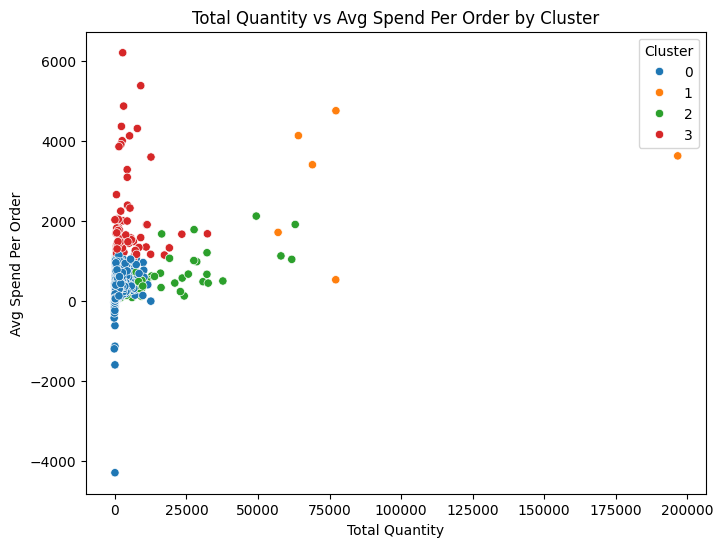

In [56]:
# 3. Scatter Plot: TotalQuantity vs AvgSpendPerOrder
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_X, x='TotalQuantity', y='AvgSpendPerOrder', hue='Cluster', palette='tab10')
plt.title('Total Quantity vs Avg Spend Per Order by Cluster')
plt.xlabel('Total Quantity')
plt.ylabel('Avg Spend Per Order')
plt.legend(title='Cluster')
plt.show()


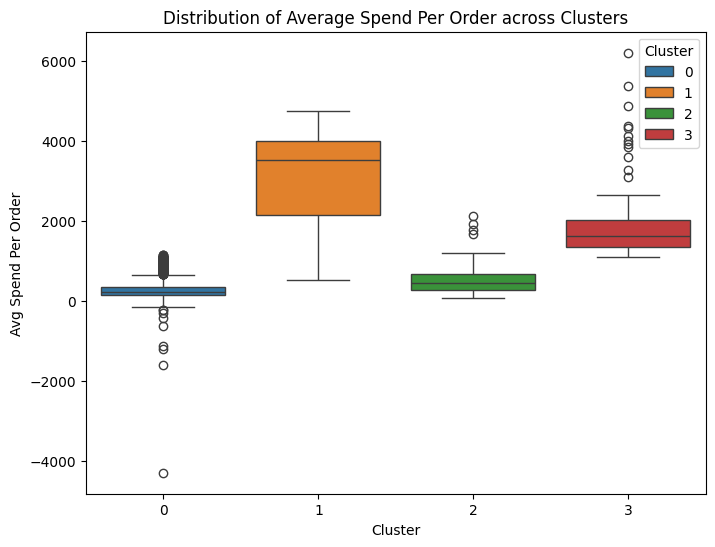

In [57]:
# 4. Box Plot: AvgSpendPerOrder across Clusters
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_X, x='Cluster', y='AvgSpendPerOrder', hue='Cluster', palette='tab10')
plt.title('Distribution of Average Spend Per Order across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Avg Spend Per Order')
plt.show()

#### 3b) Visualization of customer segmentation
The PCA scatter plot shows a clear visual separation between customer clusters, indicating effective segmentation using K-Means. The Frequency vs. Total Spend plot reveals that some customers shop often but spend moderately, while others spend heavily with fewer visits. The Total Quantity vs. Average Spend per Order plot suggests about distinct purchasing behaviors, where some customers buy in bulk with lower order values, and others place fewer, high-value orders. The box plot of Average Spend per Order across clusters emphasizes that certain clusters consist of high-spending customers, suggesting premium buyers. These insights can helpful for tailored marketing and retention strategies.